# Tfrecords guide
http://warmspringwinds.github.io/tensorflow/tf-slim/2016/12/21/tfrecords-guide/

This is a draft notebook where we create tfrecords for LibriSpeech dataset

In [2]:
import tensorflow as tf
from glob import glob
import numpy as np
import librosa

import matplotlib.pylab as plt
%matplotlib inline

import scipy

/home/julia/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/julia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# create .tfrecords file with signals and annonation info 
def _bytes_features(value):
    return tf.train.Feature(bytes_list = tf.train.BytesList(value = [value]))

def _int64_features(value):
    return tf.train.Feature(int64_list = tf.train.Int64List(value = [value]))

def convert_speakers_to_labels(labels, convertion_dict = None):
    return np.array([convertion_dict[l] for l in labels], dtype = np.int32)

def write_tfrecords(wav_path, tfrecord_path, signal_length = 40000, sr = 16000):
    wav_files = glob('{}/**/*.wav'.format(wav_path), recursive=True)

    speakers = [int(file.split('/')[-1].split('-')[0]) for file in wav_files]
    speaker_to_label = {v:k for k,v in enumerate(set(speakers))}
    
    labels = convert_speakers_to_labels(speakers, convertion_dict = speaker_to_label)

    tfrecords_filename = tfrecord_path

    with tf.python_io.TFRecordWriter(tfrecords_filename) as writer:

        original_signals = []

        for wav_file, speaker, label in zip(wav_files, speakers, labels):
            wav, sr = librosa.core.load(wav_file, sr = sr)

            if len(wav)<signal_length:
                continue
            else:
                wav = wav[:signal_length]

            annotation = (sr, speaker, label)
            original_signals.append((wav, annotation)) 

            # encode to bytes
            wav_raw = wav.tostring()

            example = tf.train.Example(features = tf.train.Features(
                feature = {
                    'signal_raw': _bytes_features(wav_raw),
                    'sr': _int64_features(sr),
                    'speaker': _int64_features(speaker),
                    'label': _int64_features(label)
                }))
            writer.write(example.SerializeToString())

In [ ]:
wav_path = '/home/julia/DeepVoice_project/LibriSpeech_small'
tfrecord_path = '{}/wavs.tfrecord'.format(wav_path)

write_tfrecords(wav_path, tfrecord_path)

# Test the correctness of tfrecords writing procedure

In [3]:
wav_path = '/home/julia/DeepVoice_project/LibriSpeech_small'
tfrecord_path = '{}/wavs.tfrecord'.format(wav_path)


wav_files = glob('{}/**/*.wav'.format(wav_path), recursive=True)

speakers = [int(file.split('/')[-1].split('-')[0]) for file in wav_files]
speaker_to_label = {v:k for k,v in enumerate(set(speakers))}

labels = convert_speakers_to_labels(speakers, convertion_dict = speaker_to_label)

sr = 16000
signal_length = 40000

tfrecords_filename = tfrecord_path

with tf.python_io.TFRecordWriter(tfrecords_filename) as writer:

    original_signals = []

    for wav_file, speaker, label in zip(wav_files, speakers, labels):
        wav, sr = librosa.core.load(wav_file, sr = sr)
        
        if len(wav)<signal_length:
            continue
        else:
            wav = wav[:signal_length]

        annotation = (sr, speaker, label)
        original_signals.append((wav, annotation)) 

        # encode to bytes
        wav_raw = wav.tostring()
#         annotation_raw = str.encode(annotation)

        example = tf.train.Example(features = tf.train.Features(
            feature = {
                'signal_raw': _bytes_features(wav_raw),
                'sr': _int64_features(sr),
                'speaker': _int64_features(speaker),
                'label': _int64_features(label)
            }))
        writer.write(example.SerializeToString())

In [5]:
# reconstruct signals and annotation info from .tfrecord file

tfrecords_filename = '/home/julia/DeepVoice_data/wavs.tfrecord'

reconstructed_signals = []

record_iterator = tf.python_io.tf_record_iterator(path = tfrecords_filename)

for string_record in record_iterator:
    
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    speaker = int(example.features.feature['speaker'].int64_list.value[0])
    label = int(example.features.feature['label'].int64_list.value[0])
    
    sr = int(example.features.feature['sr'].int64_list.value[0])
    
    signal_string = (example.features.feature['signal_raw'].bytes_list.value[0])
    
    reconstructed_signal = np.fromstring(signal_string, dtype = np.float32)
    
    reconstructed_annotation = (sr, speaker, label)
    
    reconstructed_signals.append((reconstructed_signal, reconstructed_annotation))
    

/home/julia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [6]:
short_signals = []
for signal in reconstructed_signals:
    if signal[0].shape[0] < 40000:
        short_signals.append((signal[0], signal[1]))
print(len(reconstructed_signals), len(short_signals))
print(set([s[1][1] for s in short_signals]))

18000 0
set()


In [8]:
print(original_signals[0])
print(reconstructed_signals[0])

(array([-0.00088501, -0.00076294, -0.00231934, ...,  0.00604248,
        0.0057373 ,  0.00524902], dtype=float32), (16000, 19, 0))
(array([-0.00088501, -0.00076294, -0.00231934, ...,  0.00604248,
        0.0057373 ,  0.00524902], dtype=float32), (16000, 19, 0))


In [9]:
# Compare original and reconstructed signals
for original, reconstructed in zip(original_signals, reconstructed_signals):
    
    signal, annotation= zip(original, reconstructed)
    print(np.allclose(*signal))
    print(np.allclose(*annotation))


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [15]:
wav_path = '/home/julia/DeepVoice_project/LibriSpeech_to_classify/train'

for f in glob('{}/*.wav'.format(wav_path)):
    sr, wav = scipy.io.wavfile.read(f, mmap=True)
    wavwav, _ = librosa.core.load(f, sr = 16000, dtype = np.float32)
    print(len(wav), wav.dtype, len(wavwav), wavwav.dtype)
    print(wav[:3], wavwav[:3])

161360 int16 161360 float32
[ -6 -51 -74] [-0.00018311 -0.0015564  -0.0022583 ]
158080 int16 158080 float32
[-10 -16 -35] [-0.00030518 -0.00048828 -0.00106812]
43840 int16 43840 float32
[21 20 29] [0.00064087 0.00061035 0.00088501]
111760 int16 111760 float32
[-89 -94 161] [-0.00271606 -0.00286865  0.00491333]
155520 int16 155520 float32
[15 -9 -8] [ 0.00045776 -0.00027466 -0.00024414]
44640 int16 44640 float32
[-5 61 94] [-0.00015259  0.00186157  0.00286865]
161120 int16 161120 float32
[113 108 105] [0.00344849 0.0032959  0.00320435]
51280 int16 51280 float32
[ -69 -116 -105] [-0.00210571 -0.00354004 -0.00320435]
80400 int16 80400 float32
[ 49   2 -23] [ 1.4953613e-03  6.1035156e-05 -7.0190430e-04]
82160 int16 82160 float32
[10 11  8] [0.00030518 0.00033569 0.00024414]
296400 int16 296400 float32
[-59 -60 -59] [-0.00180054 -0.00183105 -0.00180054]
452320 int16 452320 float32
[-40 -41 -36] [-0.0012207  -0.00125122 -0.00109863]
51360 int16 51360 float32
[2 1 0] [6.1035156e-05 3.0517578e

[-4  0 -3] [-1.2207031e-04  0.0000000e+00 -9.1552734e-05]
139680 int16 139680 float32
[72 85 94] [0.00219727 0.00259399 0.00286865]
209040 int16 209040 float32
[-331 -332 -345] [-0.01010132 -0.01013184 -0.01052856]
49120 int16 49120 float32
[-3 -4 -4] [-9.1552734e-05 -1.2207031e-04 -1.2207031e-04]
199360 int16 199360 float32
[-21  -5  11] [-0.00064087 -0.00015259  0.00033569]
94320 int16 94320 float32
[ 1  1 -1] [ 3.0517578e-05  3.0517578e-05 -3.0517578e-05]
68080 int16 68080 float32
[-92 -44  59] [-0.00280762 -0.00134277  0.00180054]
183680 int16 183680 float32
[ 79 -56   3] [ 2.4108887e-03 -1.7089844e-03  9.1552734e-05]
66160 int16 66160 float32
[173  55  84] [0.00527954 0.00167847 0.00256348]
174960 int16 174960 float32
[ 1 -1 25] [ 3.0517578e-05 -3.0517578e-05  7.6293945e-04]
118480 int16 118480 float32
[0 0 0] [0. 0. 0.]
319120 int16 319120 float32
[-2 -1  3] [-6.1035156e-05 -3.0517578e-05  9.1552734e-05]
168960 int16 168960 float32
[ 195  -29 -176] [ 0.00595093 -0.00088501 -0.005

104800 int16 104800 float32
[33 37 -2] [ 1.0070801e-03  1.1291504e-03 -6.1035156e-05]
180320 int16 180320 float32
[-49 -38 -40] [-0.00149536 -0.00115967 -0.0012207 ]
107840 int16 107840 float32
[28 58  9] [0.00085449 0.00177002 0.00027466]
97920 int16 97920 float32
[-67  28 188] [-0.00204468  0.00085449  0.0057373 ]
132640 int16 132640 float32
[ 11  24 -25] [ 0.00033569  0.00073242 -0.00076294]
64240 int16 64240 float32
[42 65 70] [0.00128174 0.00198364 0.00213623]
136960 int16 136960 float32
[41 35 39] [0.00125122 0.00106812 0.00119019]
81520 int16 81520 float32
[-229 -225 -228] [-0.00698853 -0.00686646 -0.00695801]
343440 int16 343440 float32
[-25 -26 -24] [-0.00076294 -0.00079346 -0.00073242]
56160 int16 56160 float32
[-15  -7 -11] [-0.00045776 -0.00021362 -0.00033569]
41520 int16 41520 float32
[-14 -16 -16] [-0.00042725 -0.00048828 -0.00048828]
103200 int16 103200 float32
[ -63  -85 -101] [-0.00192261 -0.00259399 -0.00308228]
136000 int16 136000 float32
[-3 -4 -3] [-9.1552734e-05 -

334000 int16 334000 float32
[-57   8  50] [-0.0017395   0.00024414  0.00152588]
63120 int16 63120 float32
[-56 -56 -55] [-0.00170898 -0.00170898 -0.00167847]
68720 int16 68720 float32
[-62 -51 -50] [-0.00189209 -0.0015564  -0.00152588]
229040 int16 229040 float32
[4 4 3] [1.2207031e-04 1.2207031e-04 9.1552734e-05]
52160 int16 52160 float32
[-50 -30   5] [-0.00152588 -0.00091553  0.00015259]
183680 int16 183680 float32
[2 3 8] [6.1035156e-05 9.1552734e-05 2.4414062e-04]
176320 int16 176320 float32
[ 0  0 -9] [ 0.          0.         -0.00027466]
196160 int16 196160 float32
[-53 -54 -51] [-0.00161743 -0.00164795 -0.0015564 ]
56080 int16 56080 float32
[-4 33 25] [-0.00012207  0.00100708  0.00076294]
72080 int16 72080 float32
[ 28  -4 -27] [ 0.00085449 -0.00012207 -0.00082397]
64400 int16 64400 float32
[  1  -6 -52] [ 3.0517578e-05 -1.8310547e-04 -1.5869141e-03]
90960 int16 90960 float32
[ 34 -84   4] [ 0.0010376  -0.00256348  0.00012207]
95680 int16 95680 float32
[-54 -60 -86] [-0.0016479

57760 int16 57760 float32
[-180 -110  -72] [-0.00549316 -0.00335693 -0.00219727]
46480 int16 46480 float32
[-10 -10 -43] [-0.00030518 -0.00030518 -0.00131226]
81040 int16 81040 float32
[365 357 309] [0.01113892 0.01089478 0.00942993]
121840 int16 121840 float32
[-21 -14 -56] [-0.00064087 -0.00042725 -0.00170898]
270560 int16 270560 float32
[28 36 49] [0.00085449 0.00109863 0.00149536]
124880 int16 124880 float32
[-12 -20  18] [-0.00036621 -0.00061035  0.00054932]
87040 int16 87040 float32
[-90 -83 -69] [-0.00274658 -0.00253296 -0.00210571]
214880 int16 214880 float32
[ 5 21 64] [0.00015259 0.00064087 0.00195312]
361120 int16 361120 float32
[272 302 312] [0.00830078 0.00921631 0.00952148]
259839 int16 259839 float32
[32 29 33] [0.00097656 0.00088501 0.00100708]
183840 int16 183840 float32
[ 1 -3 -2] [ 3.0517578e-05 -9.1552734e-05 -6.1035156e-05]
61760 int16 61760 float32
[25 34 38] [0.00076294 0.0010376  0.00115967]
81440 int16 81440 float32
[-107  -99  -96] [-0.00326538 -0.00302124 -0.

169360 int16 169360 float32
[-10  17   9] [-0.00030518  0.0005188   0.00027466]
40880 int16 40880 float32
[-194 -161 -130] [-0.00592041 -0.00491333 -0.00396729]
59120 int16 59120 float32
[-2 -2  0] [-6.1035156e-05 -6.1035156e-05  0.0000000e+00]
315280 int16 315280 float32
[-150 -149 -157] [-0.00457764 -0.00454712 -0.00479126]
161280 int16 161280 float32
[-99 -56  -2] [-3.0212402e-03 -1.7089844e-03 -6.1035156e-05]
47280 int16 47280 float32
[ -3 -40  -9] [-9.1552734e-05 -1.2207031e-03 -2.7465820e-04]
57200 int16 57200 float32
[-2 13  9] [-6.1035156e-05  3.9672852e-04  2.7465820e-04]
240800 int16 240800 float32
[-6 -7 -8] [-0.00018311 -0.00021362 -0.00024414]
146480 int16 146480 float32
[ 6  2 -1] [ 1.8310547e-04  6.1035156e-05 -3.0517578e-05]
76240 int16 76240 float32
[-4 -5 -4] [-0.00012207 -0.00015259 -0.00012207]
434880 int16 434880 float32
[-1 18 10] [-3.0517578e-05  5.4931641e-04  3.0517578e-04]
50160 int16 50160 float32
[ 98 169 265] [0.00299072 0.00515747 0.00808716]
104880 int16 

112960 int16 112960 float32
[3 0 3] [9.1552734e-05 0.0000000e+00 9.1552734e-05]
260640 int16 260640 float32
[2 1 1] [6.1035156e-05 3.0517578e-05 3.0517578e-05]
49280 int16 49280 float32
[-88 -15  14] [-0.00268555 -0.00045776  0.00042725]
115040 int16 115040 float32
[28 26  5] [0.00085449 0.00079346 0.00015259]
144640 int16 144640 float32
[-17  -9   3] [-5.1879883e-04 -2.7465820e-04  9.1552734e-05]
285200 int16 285200 float32
[39 49 62] [0.00119019 0.00149536 0.00189209]
92960 int16 92960 float32
[13  9 11] [0.00039673 0.00027466 0.00033569]
149440 int16 149440 float32
[-20 -35 -40] [-0.00061035 -0.00106812 -0.0012207 ]
56720 int16 56720 float32
[-33  17 -30] [-0.00100708  0.0005188  -0.00091553]
41440 int16 41440 float32
[-49 -31  -8] [-0.00149536 -0.00094604 -0.00024414]
47120 int16 47120 float32
[3 2 2] [9.1552734e-05 6.1035156e-05 6.1035156e-05]
53040 int16 53040 float32
[227 254 242] [0.00692749 0.00775146 0.00738525]
134480 int16 134480 float32
[ 19 -12  12] [ 0.00057983 -0.000366

44240 int16 44240 float32
[-13  -8   0] [-0.00039673 -0.00024414  0.        ]
126400 int16 126400 float32
[17  2  6] [5.1879883e-04 6.1035156e-05 1.8310547e-04]
118560 int16 118560 float32
[-112 -145    7] [-0.00341797 -0.00442505  0.00021362]
336240 int16 336240 float32
[-109 -111 -119] [-0.00332642 -0.00338745 -0.00363159]
103200 int16 103200 float32
[ 2 -5 -6] [ 6.1035156e-05 -1.5258789e-04 -1.8310547e-04]
228800 int16 228800 float32
[ 0 -1 -1] [ 0.0000000e+00 -3.0517578e-05 -3.0517578e-05]
52800 int16 52800 float32
[31 27  9] [0.00094604 0.00082397 0.00027466]
265360 int16 265360 float32
[0 0 0] [0. 0. 0.]
209840 int16 209840 float32
[-18 -12  37] [-0.00054932 -0.00036621  0.00112915]
98560 int16 98560 float32
[349  64  -7] [ 0.01065063  0.00195312 -0.00021362]
43600 int16 43600 float32
[-4 -5 -4] [-0.00012207 -0.00015259 -0.00012207]
70880 int16 70880 float32
[343 294 258] [0.01046753 0.00897217 0.00787354]
275200 int16 275200 float32
[0 0 0] [0. 0. 0.]
185760 int16 185760 float32

113520 int16 113520 float32
[-22 -22 -22] [-0.00067139 -0.00067139 -0.00067139]
142880 int16 142880 float32
[ 6  0 10] [0.00018311 0.         0.00030518]
43840 int16 43840 float32
[-27 -29 -28] [-0.00082397 -0.00088501 -0.00085449]
151760 int16 151760 float32
[  0 -98 -89] [ 0.         -0.00299072 -0.00271606]
69040 int16 69040 float32
[37 49 64] [0.00112915 0.00149536 0.00195312]
123760 int16 123760 float32
[-224 -177 -198] [-0.00683594 -0.00540161 -0.00604248]
40480 int16 40480 float32
[ 127   30 -199] [ 0.00387573  0.00091553 -0.006073  ]
186400 int16 186400 float32
[-37 -71 -61] [-0.00112915 -0.00216675 -0.00186157]
134320 int16 134320 float32
[10 14 15] [0.00030518 0.00042725 0.00045776]
258080 int16 258080 float32
[209 217 218] [0.00637817 0.00662231 0.00665283]
48880 int16 48880 float32
[-47 -40 -22] [-0.00143433 -0.0012207  -0.00067139]
56400 int16 56400 float32
[-56 -53 -40] [-0.00170898 -0.00161743 -0.0012207 ]
217920 int16 217920 float32
[-39 -22  -5] [-0.00119019 -0.0006713

139920 int16 139920 float32
[ 2 -1  2] [ 6.1035156e-05 -3.0517578e-05  6.1035156e-05]
45760 int16 45760 float32
[-32 -28  50] [-0.00097656 -0.00085449  0.00152588]
65120 int16 65120 float32
[ 6 26 58] [0.00018311 0.00079346 0.00177002]
126640 int16 126640 float32
[-32 -38 -35] [-0.00097656 -0.00115967 -0.00106812]
60160 int16 60160 float32
[20 27 40] [0.00061035 0.00082397 0.0012207 ]
75040 int16 75040 float32
[39 45 35] [0.00119019 0.00137329 0.00106812]
433920 int16 433920 float32
[-2 -2 -1] [-6.1035156e-05 -6.1035156e-05 -3.0517578e-05]
152880 int16 152880 float32
[-41 -54 -50] [-0.00125122 -0.00164795 -0.00152588]
99040 int16 99040 float32
[ 436    4 -466] [ 0.01330566  0.00012207 -0.01422119]
74160 int16 74160 float32
[ -3  -6 -11] [-9.1552734e-05 -1.8310547e-04 -3.3569336e-04]
76320 int16 76320 float32
[-13 -41 -20] [-0.00039673 -0.00125122 -0.00061035]
74720 int16 74720 float32
[4 1 2] [1.2207031e-04 3.0517578e-05 6.1035156e-05]
41760 int16 41760 float32
[ 0 13 -6] [ 0.         

72800 int16 72800 float32
[0 0 0] [0. 0. 0.]
128720 int16 128720 float32
[-4 -4 -3] [-1.2207031e-04 -1.2207031e-04 -9.1552734e-05]
173120 int16 173120 float32
[62 60 55] [0.00189209 0.00183105 0.00167847]
135120 int16 135120 float32
[15  0  4] [0.00045776 0.         0.00012207]
175120 int16 175120 float32
[72 60 50] [0.00219727 0.00183105 0.00152588]
61200 int16 61200 float32
[-22  -6  -8] [-0.00067139 -0.00018311 -0.00024414]
56320 int16 56320 float32
[-7 13 66] [-0.00021362  0.00039673  0.00201416]
200800 int16 200800 float32
[1 0 3] [3.0517578e-05 0.0000000e+00 9.1552734e-05]
61680 int16 61680 float32
[ -91  -98 -109] [-0.0027771  -0.00299072 -0.00332642]
54080 int16 54080 float32
[-65 -33  22] [-0.00198364 -0.00100708  0.00067139]
157920 int16 157920 float32
[-4 -1  1] [-1.2207031e-04 -3.0517578e-05  3.0517578e-05]
46400 int16 46400 float32
[-37  -7  -2] [-1.1291504e-03 -2.1362305e-04 -6.1035156e-05]
106080 int16 106080 float32
[  5 -15  -6] [ 0.00015259 -0.00045776 -0.00018311]
45

65440 int16 65440 float32
[13  9  8] [0.00039673 0.00027466 0.00024414]
84480 int16 84480 float32
[5 2 1] [1.5258789e-04 6.1035156e-05 3.0517578e-05]
141200 int16 141200 float32
[339 344 349] [0.01034546 0.01049805 0.01065063]
78080 int16 78080 float32
[-522 -540 -542] [-0.01593018 -0.01647949 -0.01654053]
81520 int16 81520 float32
[5 6 4] [0.00015259 0.00018311 0.00012207]
144480 int16 144480 float32
[5 6 6] [0.00015259 0.00018311 0.00018311]
99680 int16 99680 float32
[-24 -20 -16] [-0.00073242 -0.00061035 -0.00048828]
44480 int16 44480 float32
[63 43 -9] [ 0.00192261  0.00131226 -0.00027466]
178160 int16 178160 float32
[-196  -64  442] [-0.00598145 -0.00195312  0.01348877]
122800 int16 122800 float32
[ -54 -125 -125] [-0.00164795 -0.0038147  -0.0038147 ]
104800 int16 104800 float32
[-4 -4  5] [-0.00012207 -0.00012207  0.00015259]
214720 int16 214720 float32
[21 26 31] [0.00064087 0.00079346 0.00094604]
82801 int16 82801 float32
[-42 -27 -15] [-0.00128174 -0.00082397 -0.00045776]
1990

115600 int16 115600 float32
[ 40 -27 -74] [ 0.0012207  -0.00082397 -0.0022583 ]
105360 int16 105360 float32
[ -9 -15 -19] [-0.00027466 -0.00045776 -0.00057983]
168720 int16 168720 float32
[0 0 0] [0. 0. 0.]
340080 int16 340080 float32
[-31 -18 -14] [-0.00094604 -0.00054932 -0.00042725]
41680 int16 41680 float32
[-14  -8  -6] [-0.00042725 -0.00024414 -0.00018311]
120000 int16 120000 float32
[-9 -8 -4] [-0.00027466 -0.00024414 -0.00012207]
105200 int16 105200 float32
[-2 -4 -3] [-6.1035156e-05 -1.2207031e-04 -9.1552734e-05]
202640 int16 202640 float32
[-49 -46 -50] [-0.00149536 -0.00140381 -0.00152588]
40800 int16 40800 float32
[-148 -194 -202] [-0.0045166  -0.00592041 -0.00616455]
88480 int16 88480 float32
[-19 -13 -30] [-0.00057983 -0.00039673 -0.00091553]
203520 int16 203520 float32
[428 437 432] [0.01306152 0.01333618 0.01318359]
43440 int16 43440 float32
[-31 -36 -45] [-0.00094604 -0.00109863 -0.00137329]
108720 int16 108720 float32
[ -6 -72 -49] [-0.00018311 -0.00219727 -0.00149536

# Read and decode tfrecords
Here we show how to read and decode tfrecords created in previous section

In [13]:
def read_and_decode(filename_queue, signal_length = 40000):
    reader = tf.TFRecordReader()
    
    _, serialized_example = reader.read(filename_queue)
    
    features = tf.parse_single_example(
        serialized_example,
        features = {
           'signal_raw': tf.FixedLenFeature([], tf.string),
            'sr': tf.FixedLenFeature([], tf.int64),
            'speaker': tf.FixedLenFeature([], tf.int64),
            'label': tf.FixedLenFeature([], tf.int64) 
        })
    
    signal = tf.decode_raw(features['signal_raw'], tf.float32)
    sr = tf.cast(features['sr'], tf.int32)
    speaker = tf.cast(features['speaker'], tf.int32)  
    label = tf.cast(features['label'], tf.int32)  
    
    signal_shape = tf.stack([signal_length])
    signal = tf.reshape(signal, signal_shape)
    
    
    annotation = (sr, speaker, label)
    signals, annotations = tf.train.shuffle_batch([signal, annotation],
                                                 batch_size = 2,
                                                 capacity = 30,
                                                 num_threads = 2,
                                                 min_after_dequeue = 6)
    return signals, annotations

(40000,)
current batch
[16000    19     0]


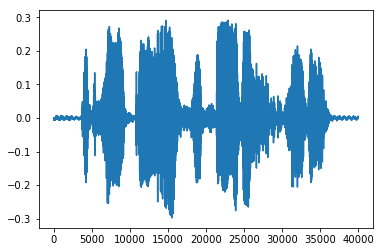

[16000    19     0]


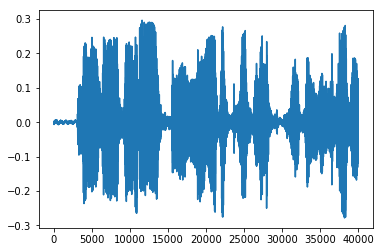

(40000,)
current batch
[16000    19     0]


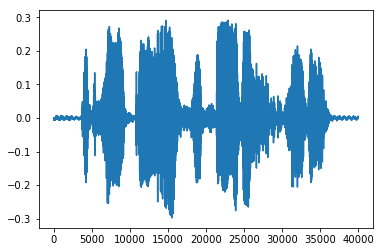

[16000    61     1]


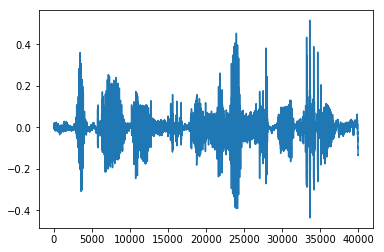

(40000,)
current batch
[16000    19     0]


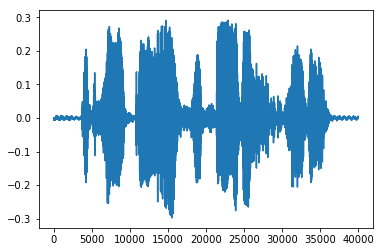

[16000    19     0]


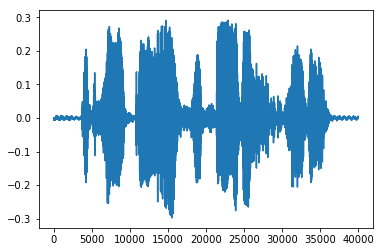

In [14]:
filename_queue = tf.train.string_input_producer(
    [tfrecords_filename], num_epochs = 3)

# Even when reading in multiple threads, share the filename
# queue.
signal, annotation  = read_and_decode(filename_queue)

init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session() as sess:
    
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Let's read off 3 batches just for example
    for i in range(3):
        
        batch_signals, batch_annotations = sess.run([signal, annotation])
        print(batch_signals[0, :].shape)
        print('current batch')
        
        print(batch_annotations[0])
        plt.plot(batch_signals[0, :])
        plt.show()
        
        print(batch_annotations[1])
        plt.plot(batch_signals[1, :])
        plt.show()
        
    coord.request_stop()
    coord.join(threads)
    
    


# LibriSpeechDataset class
We create LibriSpeechDataset class to help manage the TFRecord loading

In [2]:
class LibriSpeechDataset(object):
    '''Dataset object to help manage the TFRecord loading.'''
    
    def __init__(self, tfrecord_path, is_training = True):
        self.is_training = is_training
        self.record_path = tfrecord_path
        
    def get_example(self, batch_size):
        """Get a single example from the tfrecord file.
        Args:
          batch_size: Int, minibatch size.
        Returns:
          tf.Example protobuf parsed from tfrecord.
        """
        reader = tf.TFRecordReader()
        num_epochs = None if self.is_training else 1
        capacity = batch_size

        path_queue = tf.train.input_producer(
            [self.record_path],
            num_epochs = num_epochs,
            shuffle = self.is_training,
            capacity = capacity)

        _, serialized_example = reader.read(path_queue)
        features = {
           'signal_raw': tf.FixedLenFeature([], tf.string),
            'sr': tf.FixedLenFeature([], tf.int64),
            'speaker': tf.FixedLenFeature([], tf.int64),
            'label': tf.FixedLenFeature([], tf.int64)
        }
        example = tf.parse_single_example(serialized_example, features)
        return example
    
    def get_wavenet_batch(self, batch_size, length = 40000):
        '''Get the Tensor expression from the reader.
        Args:
          batch_size: The integer batch size.
          length: Number of timesteps of a cropped sample to produce.
        Returns:
          A dict of key:tensor pairs. This includes "speaker", "label", "wav", and "sr".
        '''
        example = self.get_example(batch_size)
        
        signal = tf.decode_raw(example['signal_raw'], tf.float32)
        sr = tf.cast(example['sr'], tf.int32)
        speaker = tf.cast(example['speaker'], tf.int32)
        label = tf.cast(example['label'], tf.int32)  
        
        annotation = (sr, speaker, label)
        
        if self.is_training:
          # random crop
            crop = tf.random_crop(signal, [length])
            crop = tf.reshape(crop, [1, length])

        else:
            # fixed center crop
            offset = (40000 - length) // 2  # 24320
            crop = tf.slice(wav, [offset], [length])
            crop = tf.reshape(crop, [1, length])
            
        crops, annotations = tf.train.shuffle_batch(
              [crop, annotation],
              batch_size,
              num_threads=4,
              capacity=500 * batch_size,
              min_after_dequeue=200 * batch_size)    
               
        crops = tf.reshape(tf.cast(crops, tf.float32), [batch_size, length])
        
        return {"wav": crops, "sr": annotations[:,0], "speaker": annotations[:,1], "label": annotations[:,2]}

In [3]:
import tensorflow as tf

wav_path = '/home/julia/DeepVoice_project/LibriSpeech_small'
tfrecord_path = '{}/wavs.tfrecord'.format(wav_path)

# Uncomment the next line if tfrecord_path doesn't exist
# write_tfrecords(wav_path, tfrecord_path)

# create dataset and load one batch
ls_dataset = LibriSpeechDataset(tfrecord_path, is_training = False)

# batch = ls_dataset.get_wavenet_batch(10, length = 40000)
# batch

In [ ]:
with tf.Session() as sess:
    example = ls_dataset.get_example(10)
    sess.run(example)

# Iterate through tfrecord file

In [35]:
def _parse_function(example_proto):
    features = {
       'signal_raw': tf.FixedLenFeature([], tf.string),
        'sr': tf.FixedLenFeature([], tf.int64),
        'speaker': tf.FixedLenFeature([], tf.int64),
        'label': tf.FixedLenFeature([], tf.int64)
    }
    
    parsed_features = tf.parse_single_example(example_proto, features)
    
    return parsed_features["signal_raw"], parsed_features["label"]

In [37]:
import tensorflow as tf

wav_path = '/home/julia/DeepVoice_project/LibriSpeech_to_classify/val'
tfrecord_path = '{}/wavs.tfrecord'.format(wav_path)

dataset = tf.data.TFRecordDataset(tfrecord_path)
dataset = dataset.map(_parse_function)

In [48]:
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

with tf.Session() as sess:
    sess.run(iterator.initializer)
    
    for i in range(2):
        signal, label = sess.run(next_element)
        signal = tf.decode_raw(signal, out_type= tf.float32)

        print('\n--------------------------')
        print(signal.eval(), label)
    


--------------------------
[ 0.0201416  -0.01922607 -0.01885986 ...  0.00595093  0.01037598
  0.01342773] 27

--------------------------
[-0.00363159 -0.00137329 -0.0015564  ... -0.10427856 -0.14440918
 -0.16452026] 18


# Notes (not important yet)

In [130]:
initial_size = 100
batch_size = 20
epochs = 10



features = tf.zeros((initial_size, 3))
labels = tf.ones(initial_size)
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
print(dataset.output_shapes)

dataset = dataset.shuffle(buffer_size = 100)
dataset = dataset.batch(batch_size)
print(dataset.output_shapes)

dataset = dataset.repeat(epochs)
iterator = dataset.make_one_shot_iterator()

next_element, next_label = iterator.get_next()
print(next_element.shape, next_label.shape)



(TensorShape([Dimension(3)]), TensorShape([]))
(TensorShape([Dimension(None), Dimension(3)]), TensorShape([Dimension(None)]))
(?, 3) (?,)


In [133]:
with tf.Session() as sess:
    for epoch in range(epochs):
        for i in range(initial_size//batch_size):
            el, label = sess.run((next_element, next_label))
            print(epoch)

0
0
0
0
0
1
1
1
1
1
2
2
2
2
2
3
3
3
3
3
4
4
4
4
4
5
5
5
5
5
6
6
6
6
6
7
7
7
7
7
8
8
8
8
8
9
9
9
9
9
